# U net on roof labels

In [1]:
!pip install mycolorpy --quiet
!pip install focal-loss --quiet

     |████████████████████████████████| 462 kB 4.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
import focal_loss as fl

import keras.backend as K
import tensorflow as tf

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [4]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [5]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [6]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 6)
(20, 128, 128, 6)
(50, 128, 128, 6)


## Show 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[141 138 128 128  58]


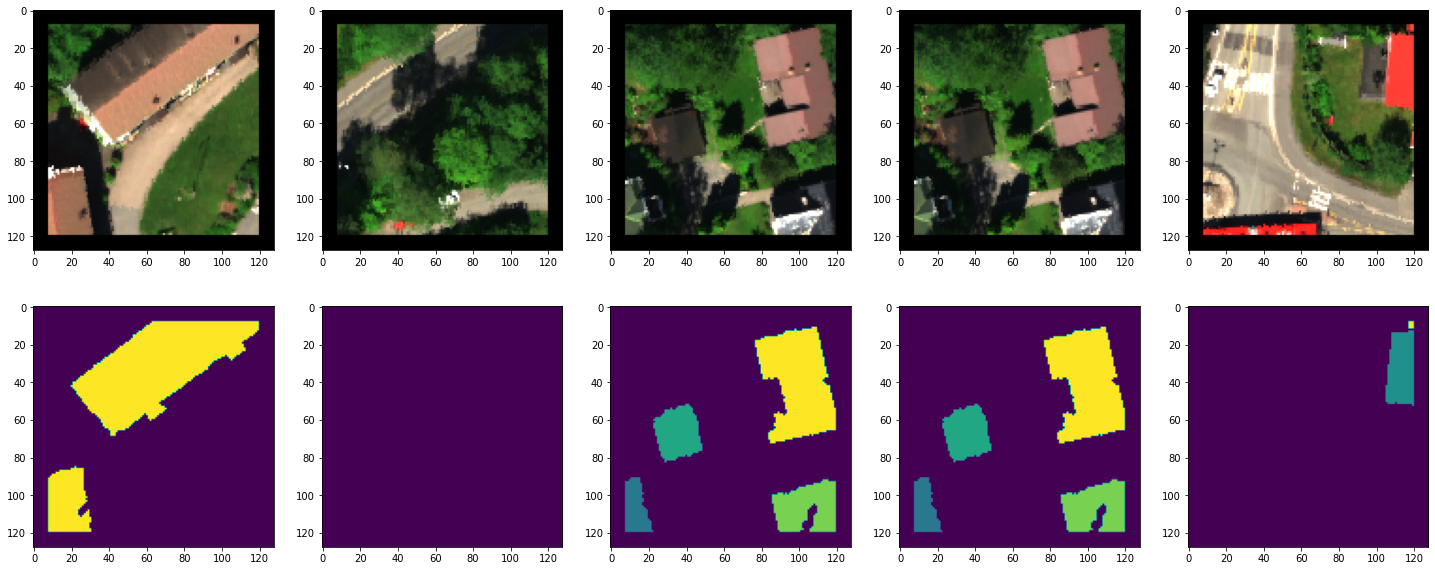

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (25,10))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
                              X_train[indx[i]][:,:,46],
                              X_train[indx[i]][:,:,21]))/2500)
    #ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(X_70_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(np.dstack((X_70_train[indx[i]][:,:,137],
    #                          X_70_train[indx[i]][:,:,194],
    #                          X_70_train[indx[i]][:,:,207])))
    ax[1,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

## Make U net

In [ ]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=6)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [8]:
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=6, last_activation='softmax')


model.compile(optimizer='adam',
                         loss='categorical_crossentropy')

In [ ]:
y_train.dtype

dtype('int32')

## Train model

In [9]:
h = model.fit(X_train,
              y_train.astype(int), 
              validation_data=(X_val,y_val), 
              batch_size=32,
              epochs=150)

Epoch 1/150
5/5 [==============================] - 22s 1s/step - loss: 1.7571 - val_loss: 58.9824
Epoch 2/150
5/5 [==============================] - 2s 408ms/step - loss: 1.5033 - val_loss: 2607.2312
Epoch 3/150
5/5 [==============================] - 2s 402ms/step - loss: 1.3189 - val_loss: 4124.1436
Epoch 4/150
5/5 [==============================] - 2s 405ms/step - loss: 1.1950 - val_loss: 4161.4165
Epoch 5/150
5/5 [==============================] - 2s 409ms/step - loss: 1.1180 - val_loss: 7480.3281
Epoch 6/150
5/5 [==============================] - 2s 407ms/step - loss: 1.0863 - val_loss: 15397.0830
Epoch 7/150
5/5 [==============================] - 2s 405ms/step - loss: 1.0356 - val_loss: 53306.5820
Epoch 8/150
5/5 [==============================] - 2s 410ms/step - loss: 0.9943 - val_loss: 28012.6055
Epoch 9/150
5/5 [==============================] - 2s 407ms/step - loss: 0.9457 - val_loss: 9232.7920
Epoch 10/150
5/5 [==============================] - 2s 404ms/step - loss: 0.9108 - 

Text(0, 0.5, 'loss')

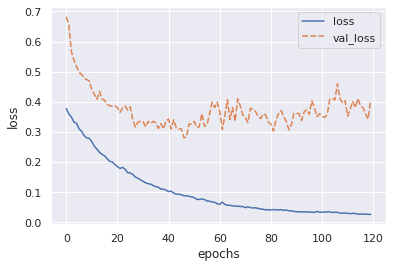

In [10]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][30:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")

In [ ]:
model.predict(X_train[0:1]).shape

(1, 128, 128, 6)

## Validate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


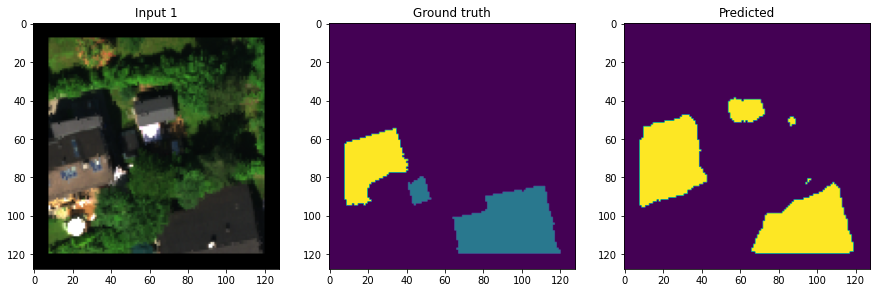

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


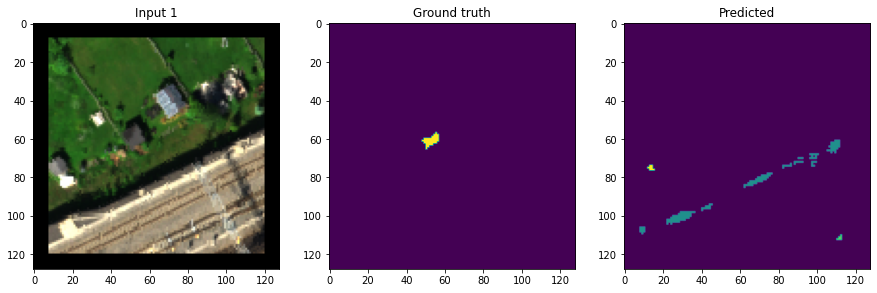

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


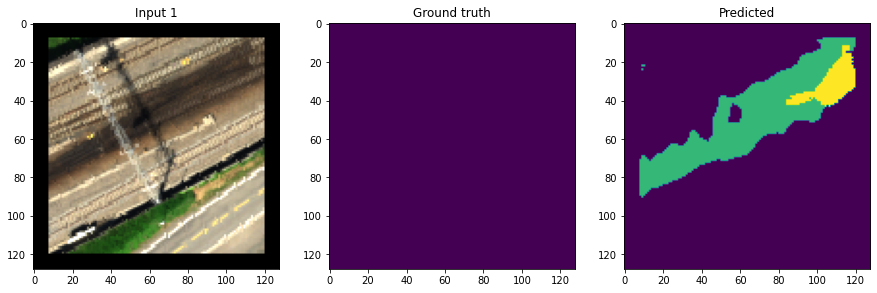

In [14]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

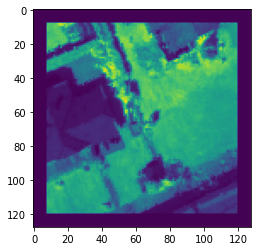

In [ ]:
plt.imshow(X_test[3,:,:,150])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


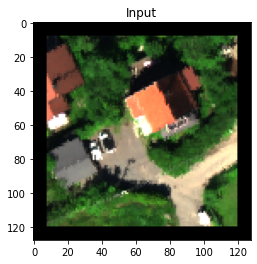

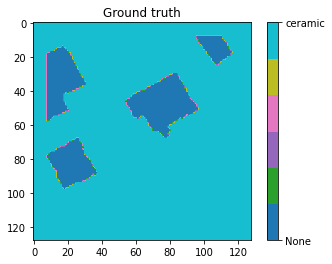

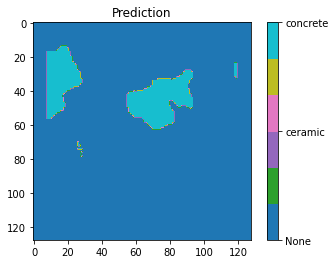

In [16]:
n = 1

plt.imshow(np.dstack([X_test[n,:,:,76], X_test[n,:,:,46], X_test[n,:,:,21]])/2500)
plt.title("Input")
plt.show()

ticks = ["None"]
ticks.extend(['ceramic',
 'concrete',
 'eternit',
 'metal',
 'tar roofing paper'])

colors=mcp.gen_color(cmap="tab10",n=6)
colormap = ListedColormap(colors)

plt.imshow(y_test[n:n+1,:,:,0][0], cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Ground truth")
plt.show()


pred = model.predict(X_test[n:n+1]).argmax(axis=3)[0]
plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Prediction")
plt.show()


## Metricks

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
pred_tot = model.predict(X_test)

In [19]:
pred_tot.argmax(axis=3).flatten()

array([0, 0, 0, ..., 0, 0, 0])

[Text(0, 0, 'None'),
 Text(0, 0, 'ceramic'),
 Text(0, 0, 'concrete'),
 Text(0, 0, 'eternit'),
 Text(0, 0, 'metal'),
 Text(0, 0, 'tar roofing paper')]

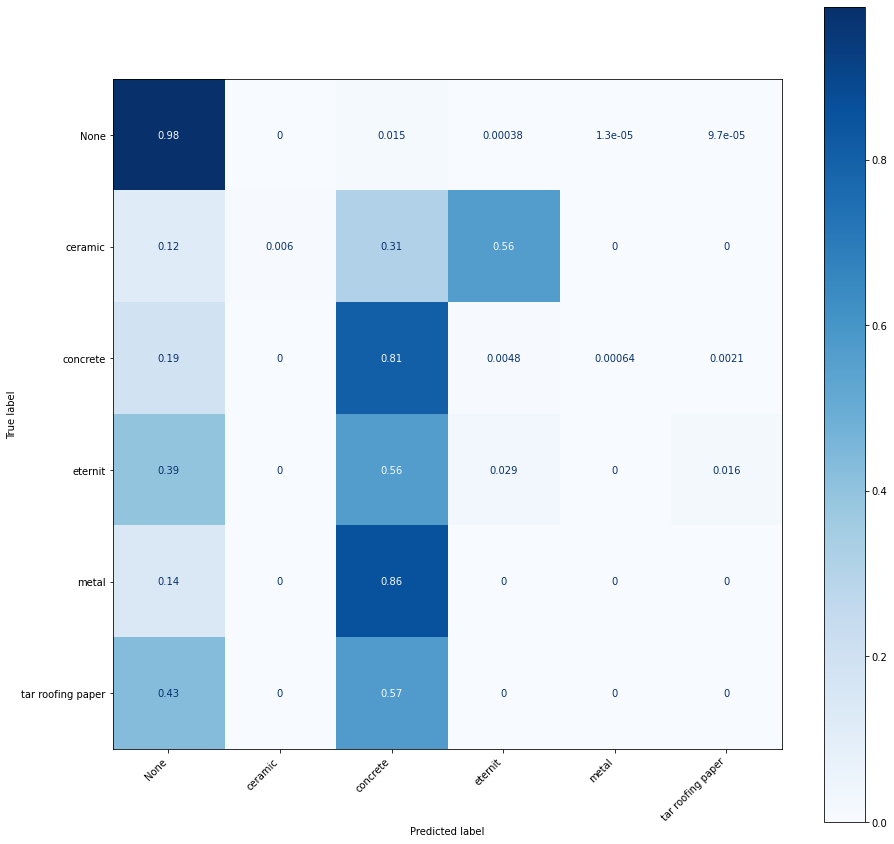

In [21]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(ticks)
true = ticks[y_test.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]

true_ = true[true != "None"]
pre_ = pre[pre != "Noen"]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")

In [22]:
from sklearn.metrics import classification_report
print(classification_report(true,pre,target_names=ticks))

                   precision    recall  f1-score   support

             None       0.99      0.98      0.99    776182
          ceramic       1.00      0.01      0.01      3662
         concrete       0.54      0.81      0.64     28048
          eternit       0.07      0.03      0.04      6260
            metal       0.00      0.00      0.00      1920
tar roofing paper       0.00      0.00      0.00      3128

         accuracy                           0.96    819200
        macro avg       0.43      0.30      0.28    819200
     weighted avg       0.96      0.96      0.96    819200



## Shallow learning

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(verbose=1, n_jobs=-1)

In [ ]:
lr.fit(X_train.reshape(150*128*128, 399)[:100000],
       y_train.reshape(150*128*128, 11).argmax(axis=1)[:100000])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.5s finished


LogisticRegression(n_jobs=-1, verbose=1)

In [ ]:
pred = lr.predict(X_test.reshape(50*128*128, 399)[:10000])

In [ ]:
y_test.reshape(50*128*128, 11).argmax(axis=1)[:10000]

array([0, 0, 0, ..., 0, 0, 0])

[Text(0, 0, 'None'),
 Text(0, 0, 'black ceramic'),
 Text(0, 0, 'black concrete'),
 Text(0, 0, 'brown concrete'),
 Text(0, 0, 'dark metal'),
 Text(0, 0, 'eternit'),
 Text(0, 0, 'grayish metal'),
 Text(0, 0, 'light metal'),
 Text(0, 0, 'red concrete'),
 Text(0, 0, 'red metal'),
 Text(0, 0, 'tar roofing paper')]

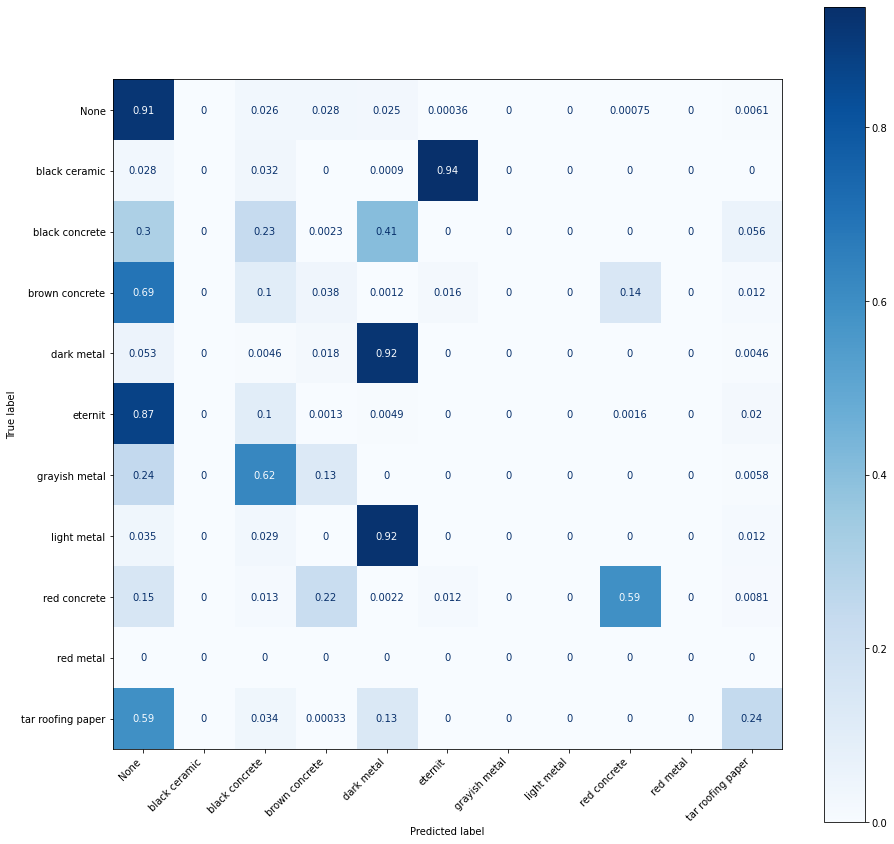

In [ ]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))
ticks = np.array(ticks)


pred = ticks[lr.predict(X_test.reshape(50*128*128, 399)[:1000000])]
true = ticks[y_test.reshape(50*128*128, 11).argmax(axis=1)[:1000000]]


disp = ConfusionMatrixDisplay.from_predictions(true, pred,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")